# **NOTE for Colab Users**

# **Do NOT write directly in this file—your work might be lost!**

# **Always make a copy before you start.**

How to make a copy

1. Click "File" in the top left.
> *If you can’t find the header (like “File” or "Runtime"), click the “v” mark at the top right to show it.*

2. "Save a copy in Drive"

3. Change the copied file’s name to “YOURNAMEs\_FileName.ipynb”.
> Ex: If your name is Olivia : Olivias_FileName.ipynb

4. Set your runtime to **CPU**. T4 GPU resets your session more often than CPU.<br>
So, it’s best to use the CPU runtime unless you need GPU for training.<br>
Check out this [Video](https://youtu.be/XRmI-qRiFFw).<br>

> If you switch the runtime halfway, you have to rerun all cells from the start.<br>
> Please pick your runtime before you begin.<br>
> *Rerunning cells: Click “Runtime” (top left) → Then click “Run before”.*<br>

---

* Check marks (✅) won’t be saved. If you reload the page with Chrome’s refresh button, they’ll disappear.<br>
If you want to pause and come back later, just add a text cell and write something like “SO FAR DONE.”

---

* In Colab, **previous outputs reset every 30 to 90 minutes**.<br>
  Because of this, errors like `~~ is not defined` will happen **very often**.

  🔁 What to do when you get an `~~is not defined` error
  1. First, make sure your variable is spelled right.<br>
  2. If it’s spelled right but you still see the error, **click the cell you want to restart**.<br>
  3. Go to “Runtime” (top left) → Click “Run before”.<br>
    → This will **re-run all previous cells**.
  4. Run the cell again.

  If you still see the error after these steps,<br>
  there might be a basic mistake in your TODO answers from earlier cells.<br>
  Please check if your answer is right.<br>
  Or ask ChatGPT or another coding assistant for help.

# **Preparation**

This section only loads content from earlier chapters.<br>
Just run the code—you don’t need to read it.<br>
Feel free to skip ahead.<br>

In [ ]:
# Donwload the file
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# Load the file called input.text that you just downloaded in utf-8.
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# A Function to Display Tensors Nicely (Feel Free to Skip This)
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Define an embedded table for vocabulary number x number of embedding dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # Get the embedded vector corresponding to the input index
        return self.token_embedding_table.forward(input_indices)

# Defining a Position Embedded Module
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # Location embedding layer
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # Get sequence length
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # Position index generation
        position_embeddings = self.position_embedding_layer(position_indices)  # Position embedding
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # Embedded layer for each token
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # Get token embedding
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # Get location embedding
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # Adding token embedding and position embedding
        embeddings = token_embeddings + position_embeddings
        return embeddings

class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # Masks are created using the lower triangular matrix (maintaining the causality of self-attention)
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # Dropout
        self.dropout = DeterministicDropout(config.dropout_rate)
        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # Batch, Token Length, Embedding Channel

        key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # Calculating Attention score (QK^T) * self.head_size **(-0.5)
        attention_scores = query @ key.transpose(-2, -1) * self.head_size**(-0.5)

        # Mask applied
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Softmax → Dropout → Weighted sum
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = attention_weights @ value  # (B, T, head_size)
        return out

class DeterministicDropout(nn.Module):
    def __init__(self, p=0.1, seed=199):
        super().__init__()
        self.p = p
        # Create a fixed random number generator
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def forward(self, x):
        if self.training:
            # Generate random numbers using a fixed generator
            mask = (torch.rand(x.shape, generator=self.generator, device=x.device, dtype=x.dtype) > self.p)
            return x * mask / (1 - self.p)
        else:
            return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim

        # Head size is the number of embedded dimensions // number of AttentionHeads. In this example, 8/2 = 4 is self.head_size.
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # Manage multiple heads with ModuleList
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # Linear layer for mixing the outputs of each head
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # Dropouts for output
        self.dropout = DeterministicDropout(config.dropout_rate)

    def forward(self, input_tensor):
        # Get output from each head
        head_outputs_list = [head(input_tensor) for head in self.attention_heads]  # List of (B, T, head_dim)

        # Concatenate outputs of all heads → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # Mixing outputs with linear transformation
        projected = self.output_projection(concatenated)

        # Apply dropout to final output
        output = self.dropout(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.embedding_dim, config.hidden_dim)  # The first layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(config.hidden_dim, config.embedding_dim)  # The second layer fully bonded layer
        self.dropout = DeterministicDropout(config.dropout_rate) # Dropout

    def forward(self, attention_output_tensor):
        hidden_tensor = self.fc1(attention_output_tensor)

        activated_tensor = self.relu(hidden_tensor)

        output_tensor = self.fc2(activated_tensor)

        final_output_tensor = self.dropout(output_tensor)

        return final_output_tensor

# Configuration class that stores model settings
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vector)
    hidden_dim = 16 # Hidden layer size in FeedForward layer
    num_attention_heads = 2  # Note Mechanism Head Number
    dropout_rate = 0.1  # Dropout probability

# Verify your settings
config = ModelConfig()

# I've just put together the processes so far so I can skip it
torch.manual_seed(1337)

# Creating an EmbeddingModule instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)
layer_norm1 = nn.LayerNorm(config.embedding_dim)
layer_norm2 = nn.LayerNorm(config.embedding_dim)
multiheadattention = MultiHeadAttention(config = config)
feedforward = FeedForward(config)

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

embeddings = embedding_module.forward(sample_input_tokens)
norm_embeddings = layer_norm1(embeddings)
multihead_attention_output = multiheadattention.forward(norm_embeddings)
residual_connection_output = multihead_attention_output + embeddings
residual_connection_output_norm = layer_norm2(residual_connection_output)
feedforward_output = feedforward.forward(residual_connection_output_norm)
print_formatted_tensor("feedforward_output", feedforward_output)

# **Chapter 9: TransformerBlock Class**

Combine all the steps so far to build a Transformer block.

The blue block in the below figure is TransformerBlock,

please note that you don't need to include Token & Position Embedding.

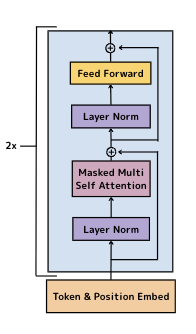

### **Section 1: Define a Class**

🔘 **Options**: There may be extra options you don't need.

`self.multihead_attention`　`self.layer_norm1`　`self.layer_norm2`　`attention_output`　`normed_input`　`self.feed_forward`　`residual_attention`　`normed_attention`　`feedforward_output`

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        normed_input = ______________(input_tensor) # Apply Layer Norm to input
        attention_output = __________________(normed_input) # Apply multi-head attention
        residual_attention = ___________ + input_tensor # residual connection
        normed_attention = ______________(residual_attention) # Apply LayerNorm again to residual output
        feedforward_output = _____________(normed_attention) # Apply feedforward network (FFN)
        final_output = _____________ + _______________ # add "before" layernorm2!

        return final_output

<details>
<summary>Click here to show/hide answer</summary>

```python
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Each LayerNorm instance stores its own scaling parameters beta and gamma.
        self.layer_norm1 = LayerNorm(config.embedding_dim)
        self.layer_norm2 = LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        # forward method is omitted.
        normed_input = self.layer_norm1(input_tensor) # Apply Layer Norm to input
        attention_output = self.multihead_attention(normed_input) # Apply multi-head attention
        residual_attention = attention_output + input_tensor
        normed_attention = self.layer_norm2(residual_attention) # Apply LayerNorm again to residual output
        feedforward_output = self.feed_forward(normed_attention) # Apply feedforward network (FFN)
        final_output = feedforward_output + residual_attention # add "before" layernorm2!

        return final_output

```

In [ ]:
# Configuration class that stores model settings
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vector)
    hidden_dim = 16 # Hidden layer size in FeedForward layer
    num_attention_heads = 2  # Note Mechanism Head Number
    dropout_rate = 0.1  # Dropout probability

In [ ]:
# Adjust seed value
torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Creating an EmbeddingModule instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)

# Creating a Transformer block instance.
transformer_block1 = # TODO: Define TransformerBlock instance.
transformer_block2 = # TODO: Define TransformerBlock instance.

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
sample_embeddings = embedding_module.forward(sample_input_tokens)

# Pass through the first Transformer block
transformer_block1_output = # TODO: Instance.Method(Argument). The forward method is usually optional.
print_formatted_tensor("transformer_block1_output", transformer_block1_output)

transformer_block2_output = # TODO: Instance.Method(Argument). The forward method is usually optional.
print_formatted_tensor("transformer_block2_output", transformer_block2_output)

**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
transformer_block1_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.14,  -2.19,   2.87,   0.55,   2.39,   0.14,   0.70,  -0.16],
           [ -0.45,  -1.65,   0.23,   0.60,  -1.84,   0.89,   2.54,  -1.43],
           [ -0.99,  -0.56,  -2.10,  -1.18,   2.15,   1.79,  -0.08,   0.11],
           [ -1.42,  -0.49,   0.39,  -1.45,   0.54,   2.88,  -0.46,  -0.94],
           [ -1.65,  -0.16,  -0.53,  -0.51,   1.34,   1.68,   0.84,   0.29],
           [ -0.07,   1.28,  -1.05,   0.13,   1.84,   0.53,   0.20,  -0.65],
           [ -1.80,  -0.87,   1.51,   0.97,   0.52,   2.43,  -0.77,   0.79],
           [ -0.59,   0.51,   0.26,  -1.04,   0.67,  -0.47,   1.94,   0.89]
         ]
       ])
transformer_block2_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.46,  -2.47,   2.64,   0.00,   3.02,   0.14,   0.11,   0.75],
           [ -1.18,  -1.49,   0.84,   0.31,  -1.74,   1.41,   1.73,  -1.31],
           [ -1.76,  -0.16,  -1.99,  -0.89,   2.49,   2.30,  -0.84,   0.13],
           [ -2.05,  -0.29,   0.39,  -1.27,   0.68,   3.41,  -1.33,  -0.94],
           [ -2.54,   0.10,  -0.19,  -0.51,   1.42,   2.23,   0.84,   0.01],
           [ -0.74,   1.28,  -1.05,   0.65,   1.95,   0.87,  -0.51,  -1.08],
           [ -2.17,  -0.67,   1.51,   1.34,   0.61,   2.98,  -1.63,   0.46],
           [ -1.53,   0.20,   0.26,  -0.95,   0.56,   0.20,   1.33,   0.61]
         ]
       ])
```

Feed the output of the first TransformerBlock into the second TransformerBlock for processing.

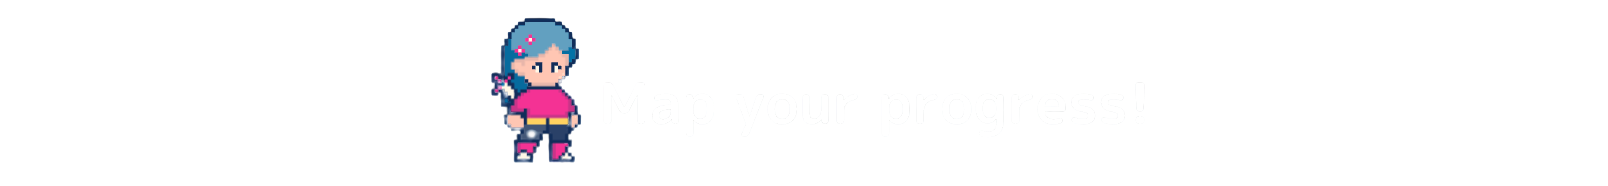

**`Chapter 9: TransformerBlock Class: Section 1: Define a Class`** <label><input type="checkbox"> Mark as Done</label>

**`Chapter 9: TransformerBlock Class:`** <label><input type="checkbox"> Mark as Done</label>